In [1]:
!pip install novosparc

     |████████████████████████████████| 62.6MB 61kB/s 
     |████████████████████████████████| 440kB 44.6MB/s 
     |████████████████████████████████| 10.3MB 19.8MB/s 
     |████████████████████████████████| 133kB 46.9MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 1.2MB 46.0MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
  Created wheel for novosparc: filename=novosparc-0.0.0-cp37-none-any.whl size=20679 sha256=3b1fda8122fa3e769d320d36905e43dab736a72cd2c36afa3fd43a32b2353d1d
  Stored in directory: /root/.cache/pip/wheels/fd/5d/3a/8222a40062650a7b1f91ccbba56bf07bc56fe85a3e15757913
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=d323b3dc264ee7fe412cc1fcc72cc4024bddf9c20d20d4f35eb4c38cebf951b0
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for sinfo: f

In [1]:
# imports
%matplotlib inline
import os
import numpy as np
import pandas as pd
import scanpy as sc
import novosparc
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!cp -r drive/MyDrive/sma02_novosparc .
data_dir = 'sma02_novosparc/'

In [ ]:
atlas.shape
locations.shape
atlas_gene_names

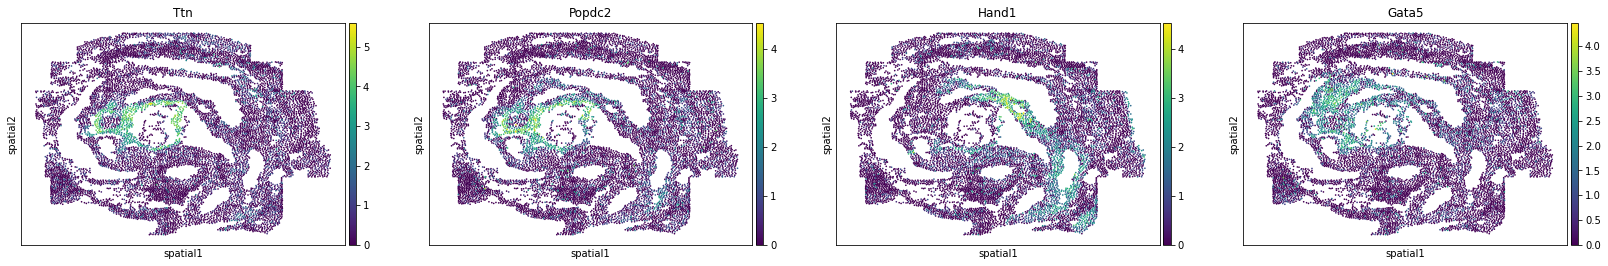

In [89]:
target_space_path = os.path.join(data_dir, 'locs_embryo1_2.txt')
locations = pd.read_csv(target_space_path, sep=',')
locations_apriori = locations[['x_coord', 'y_coord']].values
locations = locations_apriori
atlas_path = os.path.join(data_dir, 'mtx_embryo1_2.txt')
atlas = sc.read(atlas_path, delimiter=',').T
atlas_gene_names = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations
pl_genes = ['Ttn', 'Popdc2', 'Hand1', 'Gata5']
marker_genes = ['Ttn', 'Popdc2', 'Hand1', 'Gata5',  
            'Six3', 'Lhx2', 'Otx2', 'Pou3f1',
            'Sox2', 'Foxa1', 'Cldn4', 'Foxf1']
sc.pl.embedding(atlas, basis="spatial", color=pl_genes)

In [22]:
locations_circle = novosparc.geometry.construct_circle(num_locations=np.shape(locations_apriori)[0])

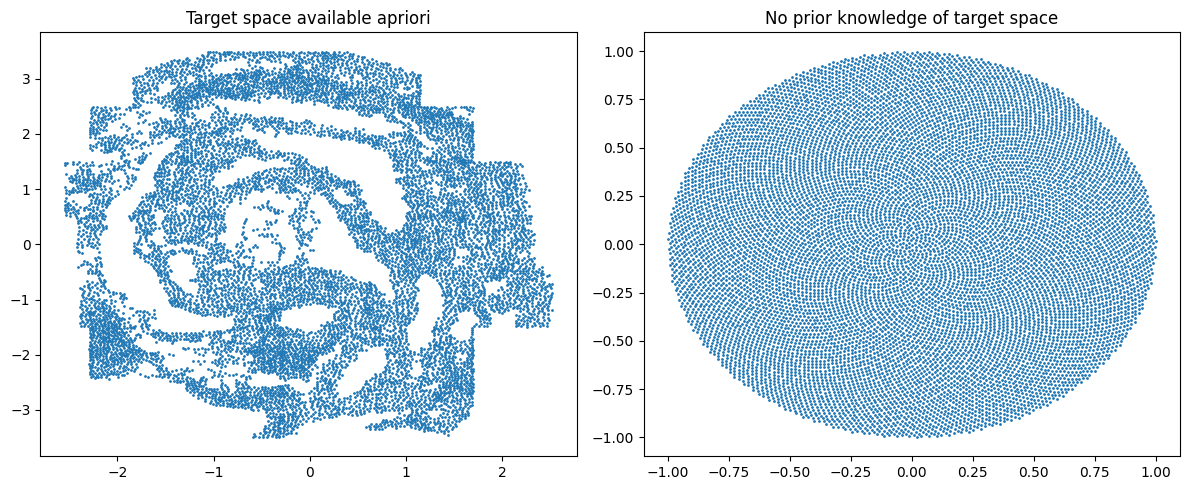

In [24]:
fig, ax = plt.subplots(1,2, figsize=(12,5), dpi= 100)
ax[0].scatter(locations_apriori[:, 0], locations_apriori[:, 1], s=1)
ax[1].scatter(locations_circle[:, 0], locations_circle[:, 1], s=1)
ax[0].set_title('Target space available apriori')
ax[1].set_title('No prior knowledge of target space')

plt.tight_layout()
plt.show()

In [27]:
data_path = os.path.join(data_dir, 'mtx_embryo1_5.txt')
dataset = sc.read(data_path, delimiter=',').T
gene_names = dataset.var.index.tolist()

ncells, ngenes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % ncells)
print('number of genes: %d' % ngenes)

# optional: subset cells
ncells = 1000
sc.pp.subsample(dataset, n_obs=ncells)

number of cells: 8353
number of genes: 351


In [28]:
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)

In [50]:
num_neighbors_s = num_neighbors_t = 5
tissue.setup_reconstruction(num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)

Setting up for reconstruction ... done ( 55.93 seconds )
Reconstructing spatial information with 351 markers: 1000 cells and 11001 locations ... 
Trying with epsilon: 5.00e-03


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


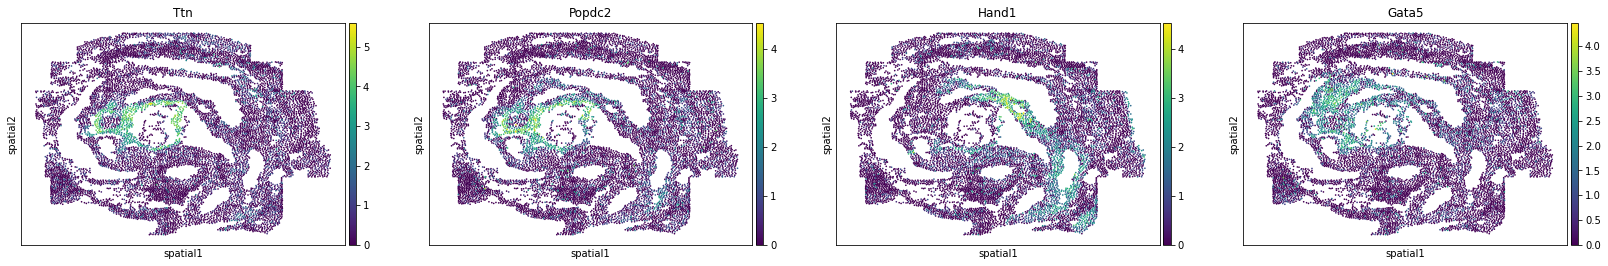

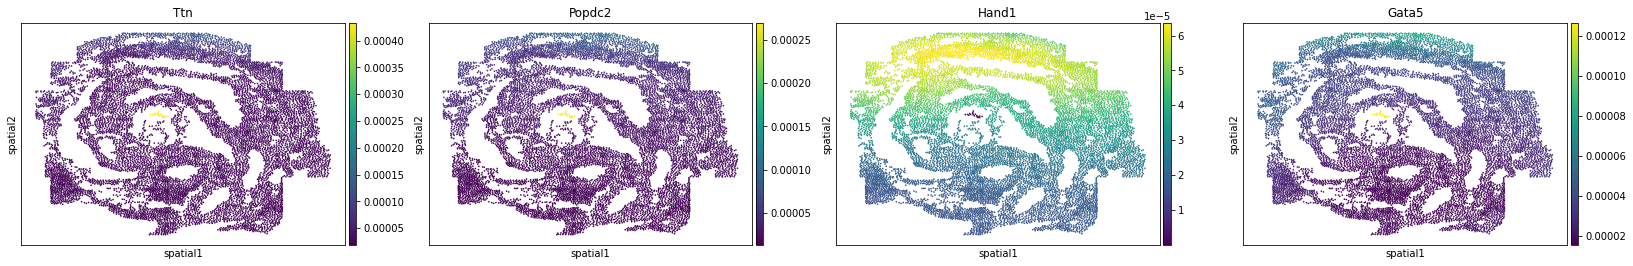

In [79]:
sdge = tissue.sdge
dataset_reconst_0 = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst_0.obsm['spatial'] = locations_apriori
sc.pl.embedding(atlas, basis="spatial", color=pl_genes)
sc.pl.embedding(dataset_reconst, basis="spatial", color=pl_genes)

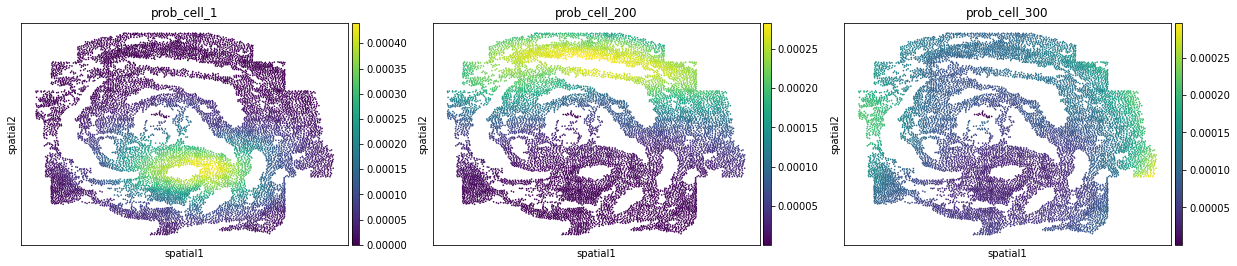

In [66]:
# probability of individual cells belonging to each location
gw = tissue.gw
ngw = (gw.T / gw.sum(1)).T
cell_idx = np.arange(ncells)
dataset_reconst_0.obs = pd.DataFrame(ngw.T, columns=['prob_cell_%d' % i for i in cell_idx])

sc.pl.embedding(dataset_reconst_0, basis="spatial", color=['prob_cell_%d' % i for i in [1, 200, 300]])

In [67]:
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_gene_names).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(ngenes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# alternative 1: setup both assumptions 
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,markers_to_use=markers_to_use, 
num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)
tissue.reconstruct(alpha_linear=0.5, epsilon=5e-3)
# alternative 2: handling each assumption separately
#tissue.setup_smooth_costs(dge_rep=dge_rep)
#tissue.setup_linear_cost(markers_to_use, atlas_matrix)

Setting up for reconstruction ... done ( 63.51 seconds )
Reconstructing spatial information with 351 markers: 1000 cells and 11001 locations ... 
Trying with epsilon: 5.00e-03


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


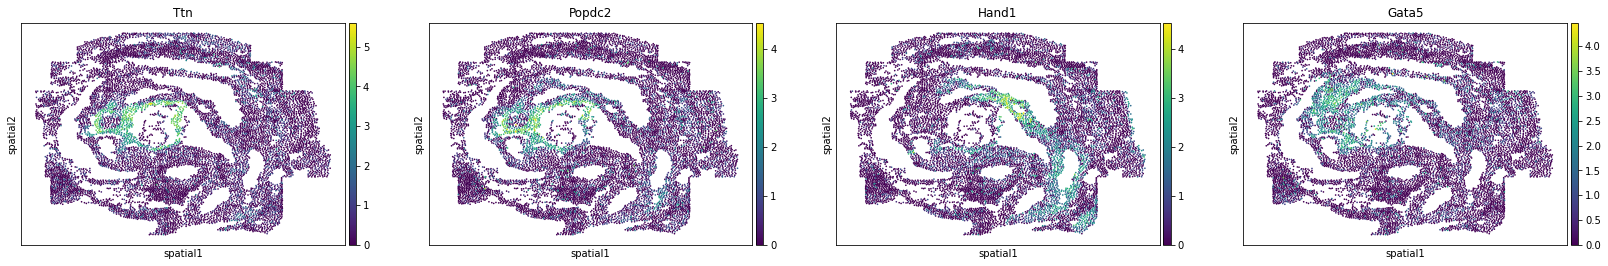

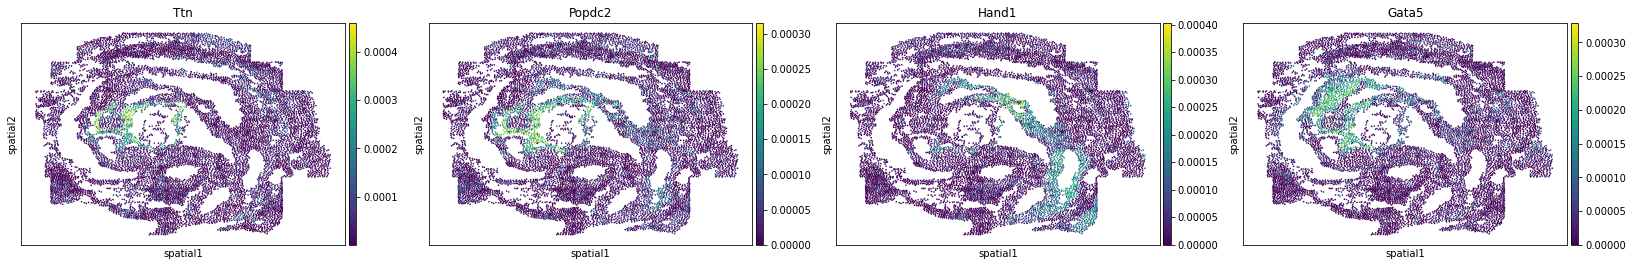

In [80]:
sdge = tissue.sdge
dataset_reconst_05 = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst_05.obsm['spatial'] = locations_apriori
sc.pl.embedding(atlas, basis="spatial", color=pl_genes)
sc.pl.embedding(dataset_reconst_05, basis="spatial", color=pl_genes)

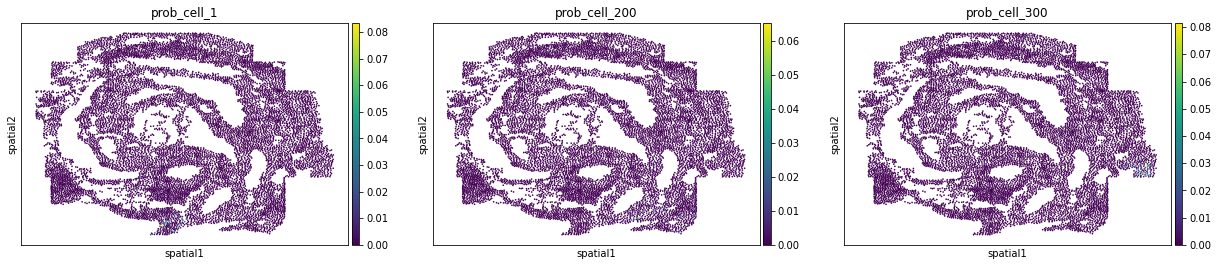

In [69]:

# probability of individual cells belonging to each location
gw = tissue.gw
ngw = (gw.T / gw.sum(1)).T
cell_idx = np.arange(ncells)
dataset_reconst_05.obs = pd.DataFrame(ngw.T, columns=['prob_cell_%d' % i for i in cell_idx])

sc.pl.embedding(dataset_reconst_05, basis="spatial", color=['prob_cell_%d' % i for i in [1, 200, 300]])

In [70]:
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_gene_names).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(ngenes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# alternative 1: setup both assumptions 
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,markers_to_use=markers_to_use, 
num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)
tissue.reconstruct(alpha_linear=0.8, epsilon=5e-3)
# alternative 2: handling each assumption separately
#tissue.setup_smooth_costs(dge_rep=dge_rep)
#tissue.setup_linear_cost(markers_to_use, atlas_matrix)

Setting up for reconstruction ... done ( 57.76 seconds )
Reconstructing spatial information with 351 markers: 1000 cells and 11001 locations ... 
Trying with epsilon: 5.00e-03


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


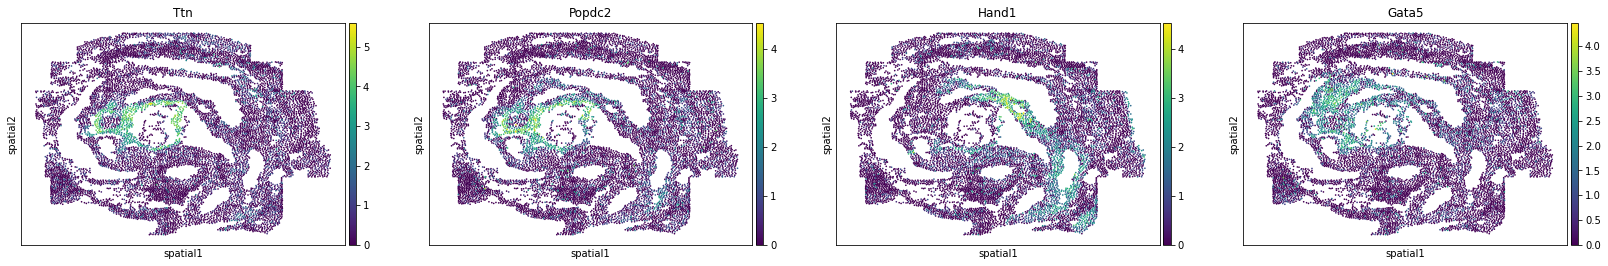

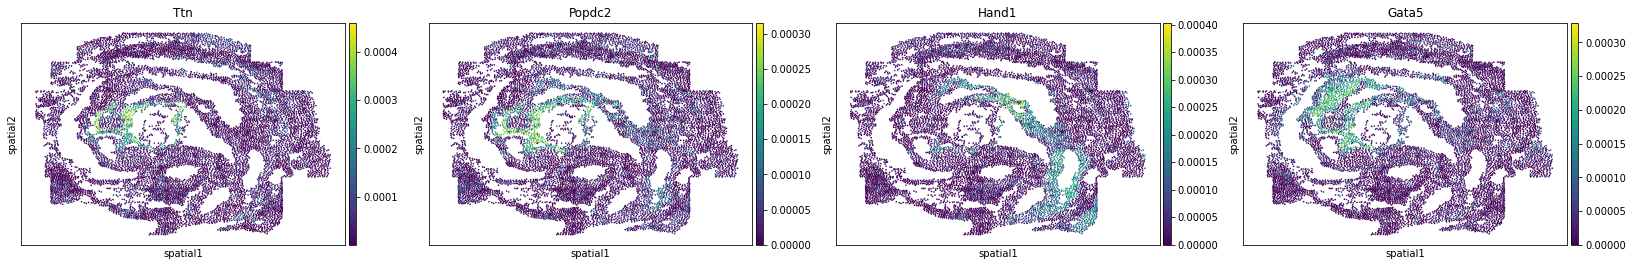

In [81]:
sdge = tissue.sdge
dataset_reconst_08 = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst_08.obsm['spatial'] = locations_apriori
sc.pl.embedding(atlas, basis="spatial", color=pl_genes)
sc.pl.embedding(dataset_reconst_08, basis="spatial", color=pl_genes)

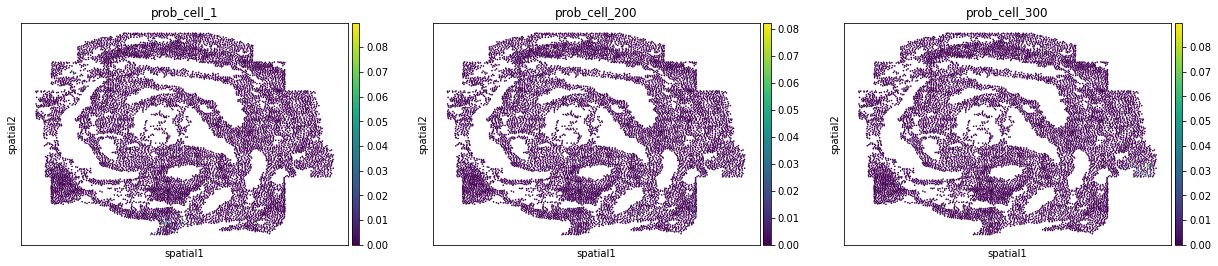

In [72]:
# probability of individual cells belonging to each location
gw = tissue.gw
ngw = (gw.T / gw.sum(1)).T
cell_idx = np.arange(ncells)
dataset_reconst_08.obs = pd.DataFrame(ngw.T, columns=['prob_cell_%d' % i for i in cell_idx])

sc.pl.embedding(dataset_reconst_08, basis="spatial", color=['prob_cell_%d' % i for i in [1, 200, 300]])

In [90]:
atlas_sub = atlas[:, marker_genes]
atlas_gene_names = atlas_sub.var.index.tolist()
atlas.obsm['spatial'] = locations
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_gene_names).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(ngenes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# alternative 1: setup both assumptions 
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,markers_to_use=markers_to_use, 
num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)
tissue.reconstruct(alpha_linear=0.8, epsilon=5e-3)
# alternative 2: handling each assumption separately
#tissue.setup_smooth_costs(dge_rep=dge_rep)
#tissue.setup_linear_cost(markers_to_use, atlas_matrix)

Setting up for reconstruction ... done ( 56.35 seconds )
Reconstructing spatial information with 12 markers: 1000 cells and 11001 locations ... 
Trying with epsilon: 5.00e-03


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


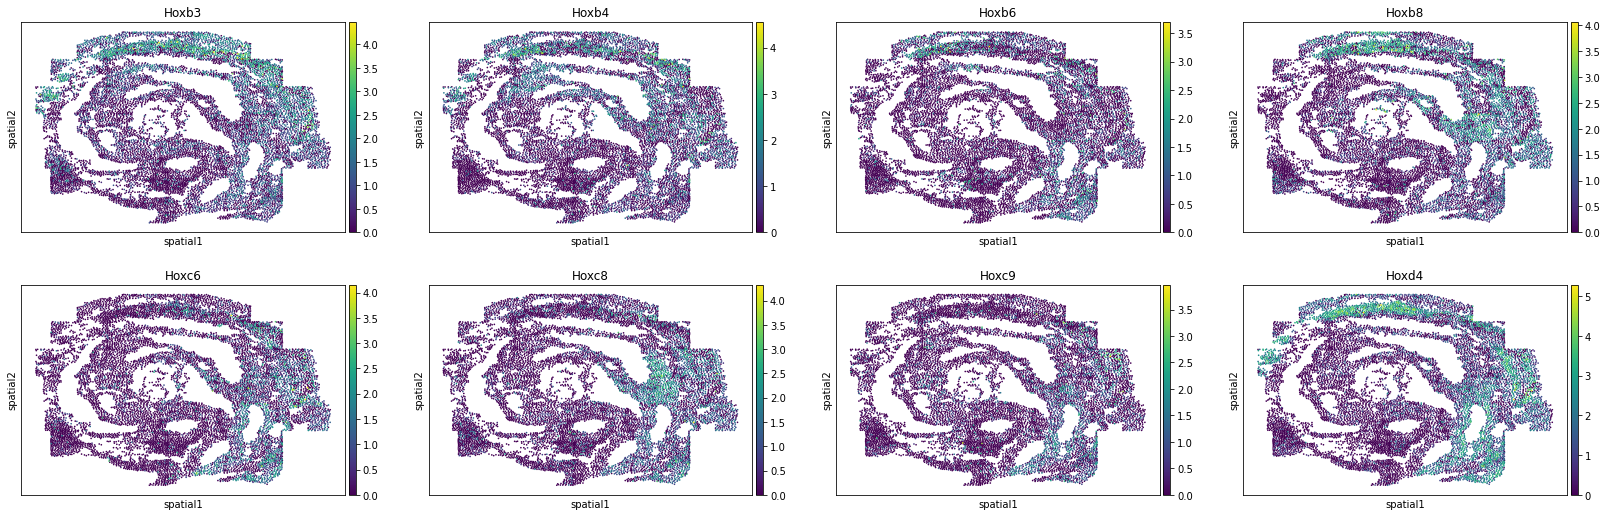

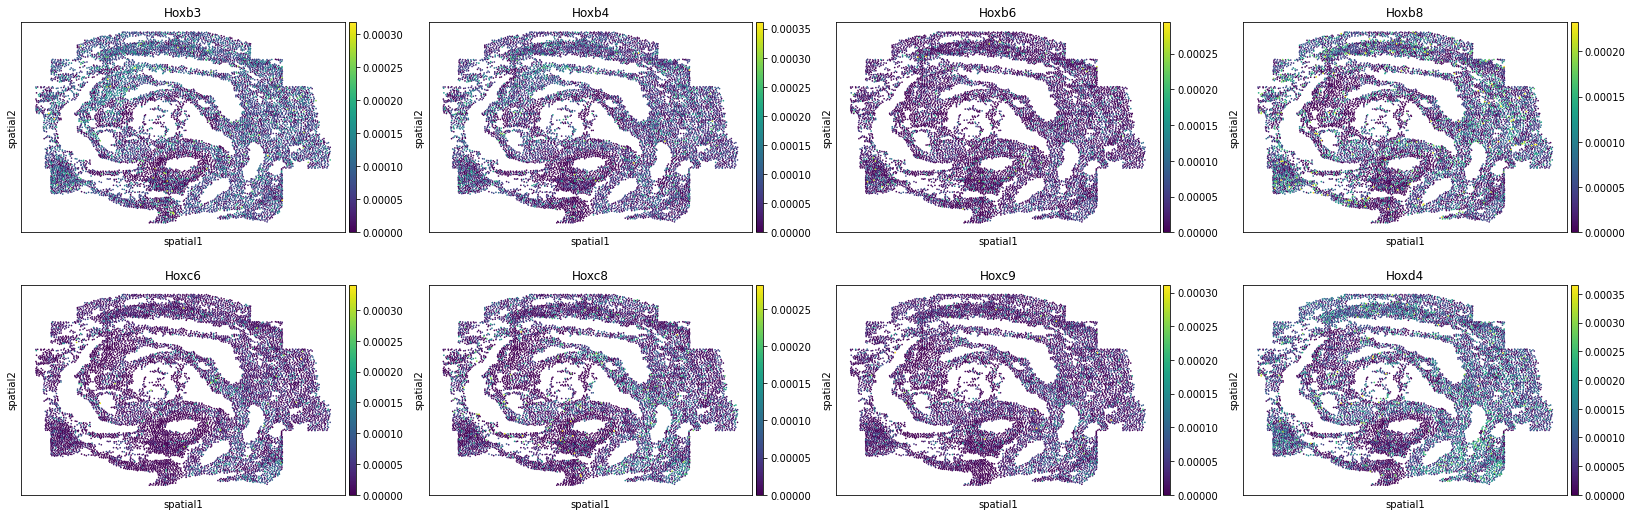

In [93]:
sdge = tissue.sdge
dataset_reconst_08_subset = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst_08_subset.obsm['spatial'] = locations_apriori
pl_genes = ['Hoxb3', 'Hoxb4', 'Hoxb6', 'Hoxb8',
            'Hoxc6', 'Hoxc8', 'Hoxc9', 'Hoxd4']
sc.pl.embedding(atlas, basis="spatial", color=pl_genes)
sc.pl.embedding(dataset_reconst_08_subset, basis="spatial", color=pl_genes)